# Pseudocode zur Implementierung

In [2]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os
from IPython.display import display, HTML

In [3]:
# dieser Test-df wird von Christophs Programm erzeugt.
# wichtig!!! Bei der Besprechung müssen wir P_delta als NaN Value in den Datenframe einfügen

#Event dataframe anlegen zur späteren Auswertung der An/Abschaltevents
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                   'Ladevorgang', 'Status', 'Ladeleistung',
                                   'minuten_index_Abschaltung','timestamp_abschalt'])
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])

Leerlaufleistung_Phase = 0

## Funktion
-------

In [4]:
def add_p_delta(df):
    df_length = len(df)
    index_last_row = df_length - 1
    if(df_length > 1):
        p_new = df.iloc[index_last_row]['P']
        p_old = df.iloc[index_last_row-1]['P']
        p_delta = p_new - p_old
        return p_delta
    else:
        return 0

In [19]:
def detect_switch_event(rows, phase, Event_df):
    minuten_index = rows.index[-1]
    timestamp = rows.iloc[-1]['timestamp']
    Leerlaufleistung_Phase = dict[phase].iloc[0]['P']  
    ### Einschaltvorgang dedektieren ###
    # ist delta P relevant
    if(rows.iloc[-1]['P_delta'] > 200):
        # Prüfen ob Ladenvorgang beginnt/beendet
        # Wenn delta P positiv ---> event kreieren um später zu checken ob es ein Einschaltvorgang war
        Event_df.loc[len(Event_df)]= [timestamp, phase, minuten_index, 'ein', 'not checked', 0,0,0]
    
    #Check events: Überprüfen ob vorher eingetragenes event wirklich ein Einschaltvorgang ist
    event_df_length = len(Event_df)
    row_event = 0
    while row_event < event_df_length:
            #condition to check event
            minuten_index_event = Event_df.iloc[row_event]['minuten_index']
            #Check auf Einschaltvorgang
            if ((minuten_index_event+3 == minuten_index) & 
                (Event_df.iloc[row_event]['Ladevorgang'] == 'ein') &
                (Event_df.iloc[row_event]['Phase'] == phase)):
                Ladeleistung = rows.loc[minuten_index_event+3]['P'] - rows.loc[minuten_index_event-3]['P']            
                sum_delta_P = rows.loc[minuten_index_event:minuten_index_event+3]['P_delta'].sum()
                deviation = abs(Ladeleistung-sum_delta_P)/Ladeleistung 
                
                #print('deviation: {}'.format(deviation))
                #print('Ladeleistung: {}'.format(Ladeleistung))
                #print('minute: {}'.format(minuten_index_event))
                if ((deviation > 0.10) | (Ladeleistung < 2500)):
                    Event_df = Event_df.drop(row_event)
                    Event_df = Event_df.reset_index(drop=True)
                else:
                    Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', Ladeleistung]
            event_df_length = len(Event_df)
            row_event += 1
         
    ### Ausschaltvorgang dedektieren ###
    #Checken ob aktuelle Leistung das Ende eines Einschaltvorgangs impliziert        
    if (('ein' in Event_df['Ladevorgang'].unique()) &
        ('checked' in Event_df['Status'].unique())):
        # create df with charging status on
        only_load_event_df = Event_df[(Event_df['Ladevorgang'] == 'ein') &
                                      (Event_df['minuten_index'] < minuten_index)]
        # Soll Leistung = Leistung die auf der Phase anliegen sollte,
        # wenn alle zuvor ladenden Autos noch an der Phase hängen würden
        
        Soll_Leistung = Leerlaufleistung_Phase + Event_df[(Event_df['Ladevorgang']=='ein') & 
                                                          (Event_df['minuten_index'] <= minuten_index) & 
                                                          (Event_df['minuten_index_Abschaltung'] == 0) & 
                                                          (Event_df['Phase'] == phase)]['Ladeleistung'].sum()
        #Aktuelle Leistung (neuer Messwert)
        Ist_Leistung = rows.iloc[-1]['P']
        #Residuale Leistung 
        P_residual = Soll_Leistung - Ist_Leistung
        #Überprüfen ob fehlende Leistung (P_residual) zu einem zuvor ladenden Auto passt
        only_load_event_df['deviation_P'] = only_load_event_df['Ladeleistung']. \
                                    apply(lambda ladeleistung_auto: abs(ladeleistung_auto-P_residual)/ladeleistung_auto)
        display(only_load_event_df)
        print('minute: '+ minuten_index)
        if ((only_load_event_df['deviation_P'] < 0.03).any()):
            # sort load events by size
            # und nehme das erste Event, was der aktuellen leistung am nächsten ist
            charg_off_ev_index = only_load_event_df['deviation_P'].sort_values().index[0]
            Event_df.loc[charg_off_ev_index,['minuten_index_Abschaltung']] = minuten_index
            Event_df.loc[charg_off_ev_index,['timestamp_abschalt']] = timestamp
            Event_df.loc[charg_off_ev_index, ['Ladevorgang']] = 'aus'
            
    return Event_df

In [6]:
def combine_charging_events(Event_df):
    # Zusammenfassen von mehrphasigen Ladevorängen
    for events in range(0,len(Event_df)):
        timestamp = Event_df.iloc[events]['timestamp']
        timestamp_abschaltung = Event_df.iloc[events]['timestamp_abschalt']
        Phase = []
        Ladeleistung = []
        same_events = Event_df.loc[Event_df['timestamp'] == Event_df.iloc[events]['timestamp']]
        event_count = len(same_events)
        for a in range (0,event_count):
            Phase.append(same_events.iloc[a]['Phase'])
            Ladeleistung.append(str(same_events.iloc[a]['Phase'])+': '+str(same_events.iloc[a]['Ladeleistung']))
        if (len(ladevorgang_df.loc[ladevorgang_df['timestamp_start'] == timestamp]) !=1):
            ladevorgang_df.loc[len(ladevorgang_df)]= [timestamp, Phase, Ladeleistung, timestamp_abschaltung]
            
    return ladevorgang_df

## Code Simulation auf dem Server
----
Hier kann der Code für eine Phase Simuliert werden

In [20]:
%%time

Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                   'Ladevorgang', 'Status', 'Ladeleistung',
                                   'minuten_index_Abschaltung','timestamp_abschalt'])
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])



#Looping over dates
for filename in os.listdir('HDF5'):
    if (filename[6:7]=='0'):
        date = filename[-13:-3]
    else:
        continue
    P_Phase_1 = pd.read_hdf('HDF5/phase_1_' + date + '.h5',columns =['P', 'timestamps'])
    P_Phase_2 = pd.read_hdf('HDF5/phase_2_' + date + '.h5',columns =['P', 'timestamps'])
    P_Phase_3 = pd.read_hdf('HDF5/phase_3_' + date + '.h5',columns =['P', 'timestamps'])
    dict = {1:P_Phase_1,2:P_Phase_2,3:P_Phase_3}
    P_Phase_1 = P_Phase_1[['P','timestamp']]
    P_Phase_2 = P_Phase_2[['P','timestamp']]
    P_Phase_3 = P_Phase_3[['P','timestamp']]
    
    P_Phase_1['P_delta'] = 0
    P_Phase_2['P_delta'] = 0
    P_Phase_3['P_delta'] = 0
    
    P_Phase_1= P_Phase_1.groupby(np.arange(len(P_Phase_1))//300).mean()
    P_Phase_2= P_Phase_2.groupby(np.arange(len(P_Phase_2))//300).mean()
    P_Phase_3= P_Phase_3.groupby(np.arange(len(P_Phase_3))//300).mean()

    pseudocode_df_1 = pd.DataFrame([])
    pseudocode_df_2 = pd.DataFrame([])
    pseudocode_df_3 = pd.DataFrame([])
    phasen_variable = 1


    for row in range(0, len(P_Phase_1)):
        #Phase 1
        
        pseudocode_df_1 = pseudocode_df_1.append(P_Phase_1[row:row+1])

        # call the function to add P-delta
        pseudocode_df_1.iloc[-1, pseudocode_df_1.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_1[-2:])

        # Detect all switch events
        Event_df = detect_switch_event(pseudocode_df_1.iloc[-7:], 1, Event_df)

        # Phase 2
        pseudocode_df_2 = pseudocode_df_2.append(P_Phase_2[row:row+1])
        pseudocode_df_2.iloc[-1, pseudocode_df_2.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_2[-2:])
        Event_df = detect_switch_event(pseudocode_df_2.iloc[-7:], 2, Event_df)

        # Phase 3
        pseudocode_df_3 = pseudocode_df_3.append(P_Phase_3[row:row+1])
        pseudocode_df_3.iloc[-1, pseudocode_df_3.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_3[-2:])
        Event_df = detect_switch_event(pseudocode_df_3.iloc[-7:], 3, Event_df)
    
    

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


deviation: 8.973552570203234e-06
Ladeleistung: 3514.763717651367
minute: 358


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


deviation: 3.767462373198535
Ladeleistung: 427.9150390625
minute: 361
deviation: 0.00041609247951688807
Ladeleistung: 3478.3040161132812
minute: 722
deviation: 9.254166845442431e-05
Ladeleistung: 3877.449905395508
minute: 792
deviation: 0.0008108428839713832
Ladeleistung: 3873.886474609375
minute: 792
deviation: 9.682159552002493e-06
Ladeleistung: 3905.252655029297
minute: 792
deviation: 0.13551075407275234
Ladeleistung: 3877.029312133789
minute: 793
deviation: 0.13616319073227606
Ladeleistung: 3872.984375
minute: 793
deviation: 0.13540523925548517
Ladeleistung: 3902.8692779541016
minute: 793
deviation: 0.035816447531788254
Ladeleistung: 2906.2705078125
minute: 823
deviation: 0.5818065985766265
Ladeleistung: 2965.35009765625
minute: 824
deviation: 0.013814556968539086
Ladeleistung: 2971.1753540039062
minute: 824
deviation: 0.009306121968995808
Ladeleistung: 3653.9287109375
minute: 858
deviation: 0.7116617362185916
Ladeleistung: 3657.567626953125
minute: 859
deviation: 57.52066465576546

In [21]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.502078e+09,3,358,aus,checked,3514.76,634,1.50209e+09
1,1.502100e+09,2,722,aus,checked,3478.3,822,1.50211e+09
2,1.502104e+09,1,792,aus,checked,3877.45,825,1.50211e+09
3,1.502104e+09,2,792,aus,checked,3873.89,824,1.50211e+09
4,1.502104e+09,3,792,ein,checked,3905.25,0,0
5,1.502106e+09,2,823,aus,checked,2906.27,980,1.50212e+09
6,1.502106e+09,3,824,ein,checked,2971.18,0,0
7,1.502108e+09,3,858,aus,checked,3653.93,998,1.50212e+09


In [10]:
combine_charging_events(Event_df)

,timestamp_start,Phasen,Durchschnittliche Ladeleistung,Ladevorgang_ende
0,1.502078e+09,[3],[3: 3514.76371765],1.502095e+09
1,1.502100e+09,[2],[2: 3478.30401611],1.502106e+09
2,1.502104e+09,"[1, 2, 3]","[1: 3877.4499054, 2: 3873.88647461, 3: 3905.25...",1.502106e+09
3,1.502108e+09,[3],[3: 3653.92871094],1.502120e+09


<IPython.core.display.Javascript object>


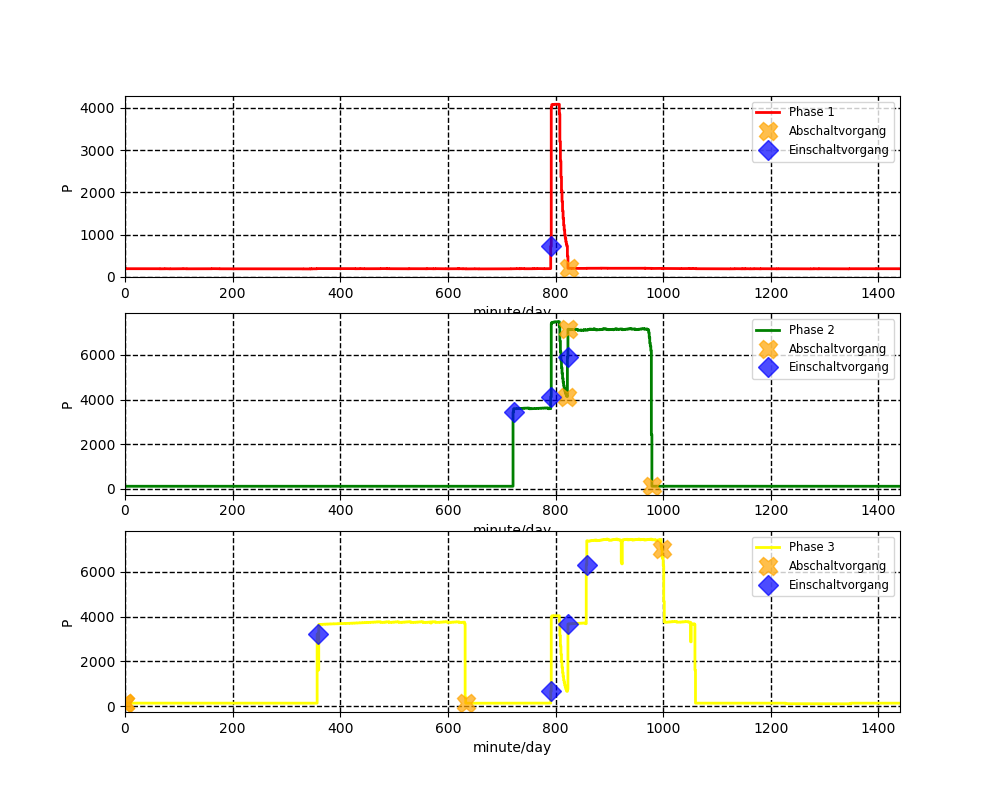

In [22]:
colors_phase = ['red','green','yellow']
dict = {1:P_Phase_1,2:P_Phase_2,3:P_Phase_3}
plt.figure(figsize=(10,8))
for Phase in range (1,4):
    Phase_P = dict[Phase]
    plt.subplot(310+Phase)
    plt.step(Phase_P.index,Phase_P['P'], color=colors_phase[Phase-1], linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung']]['P'], "X",color="orange", markersize=13,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index']]['P'], "D", color="blue", markersize=10,alpha=.7, label='Einschaltvorgang')
    plt.legend(loc='upper right', frameon=True, fontsize = 'small')
    plt.grid(color='k', linestyle='--', linewidth=1)
    plt.xlim([0,1440])
    plt.ylabel('P')
    plt.xlabel('minute/day')

In [18]:
pseudocode_df_1[790:795]

,P,timestamp,P_delta
790,197.783432,1.502104e+09,-0.579651
791,198.004257,1.502104e+09,0.220825
792,723.162598,1.502104e+09,525.158340
793,4016.516357,1.502104e+09,3293.353760
794,4075.901611,1.502104e+09,59.385254
